In [ ]:
from __future__ import print_function, division
import torch
import torch.nn as nn #파이토치 nn모듈 임포트
import torch.optim as optim # PyTorch optim패키지 임포트
from torch.optim import lr_scheduler # 학습률 스케쥴러 임포트
import numpy as np # 넘파이 임포트
import torchvision 
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # 대화형 모드

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#pip install split-folders tqdm  # train ,val, test 데이터 분리를 위한 split-folders 설치

In [ ]:
#import splitfolders 
#splitfolders.ratio('/content/drive/MyDrive/CARS', output="/content/drive/MyDrive/CARC", seed=77, ratio=(.8, 0.1, 0.1)) # train : val : test  8:1:1 비율로 나눠서 새로운 경로에 저장 

In [ ]:
# 학습을 위해 데이터 증가(augmentation) 및 일반화(normalization)
# 검증을 위한 일반화

data_transforms = {
    'train': transforms.Compose([  # 이미지 변형시키기
       transforms.Resize((224, 224)),
       transforms.RandomCrop(150), # 랜덤으로 자름
       transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2), # 색 변조
        transforms.RandomHorizontalFlip(p = 1), # 수평으로 이미지 뒤집기
        transforms.ToTensor(), # 이미지 데이터를 tensor로 바꿔준다.
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # 이미지 정규화
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)), # 이미지 사이즈를 resize로 변경한다.
        #transforms.CenterCrop(200), # 이미지 중앙을 resize × resize로 자른다
        transforms.ToTensor(), # 이미지 데이터를 tensor로 바꿔준다.
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # 이미지 정규화
        
    ]),

    'test': transforms.Compose([
        transforms.Resize((224, 224)), # 이미지 사이즈를 resize로 변경한다.
        #transforms.CenterCrop(200), # 이미지 중앙을 resize × resize로 자른다
        transforms.ToTensor(), # 이미지 데이터를 tensor로 바꿔준다.
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # 이미지 정규화
        
    ]),


}

data_dir = '/content/drive/MyDrive/CARC' # train, val, test 경로설정

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), # 설정한 경로에서 이미지를 가져오고 리사이즈에서 데이터저장
                                          data_transforms[x])
                  for x in ['train', 'val','test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32, # 배치사이즈 32
                                             shuffle=True, num_workers=2)
              for x in ['train', 'val', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # gpu사용불가면 cpu를 사용.

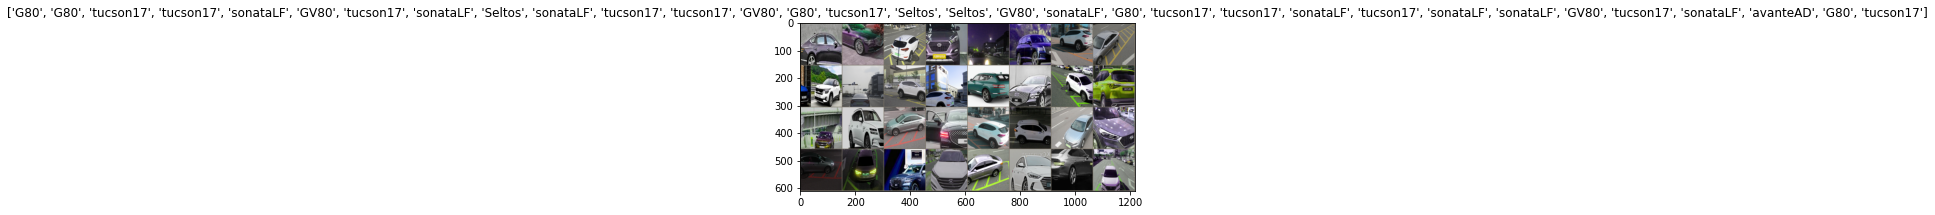

In [ ]:
def imshow(inp, title=None): # 사용할 이미지의 일부를 보여줌(train)
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  

inputs, classes = next(iter(dataloaders['train'])) # 학습 데이터의 배치를 얻습니다.
out = torchvision.utils.make_grid(inputs) # 배치로부터 격자 형태의 이미지를 만듭니다.

imshow(out, title=[class_names[x] for x in classes]) # 이미지 보여주기


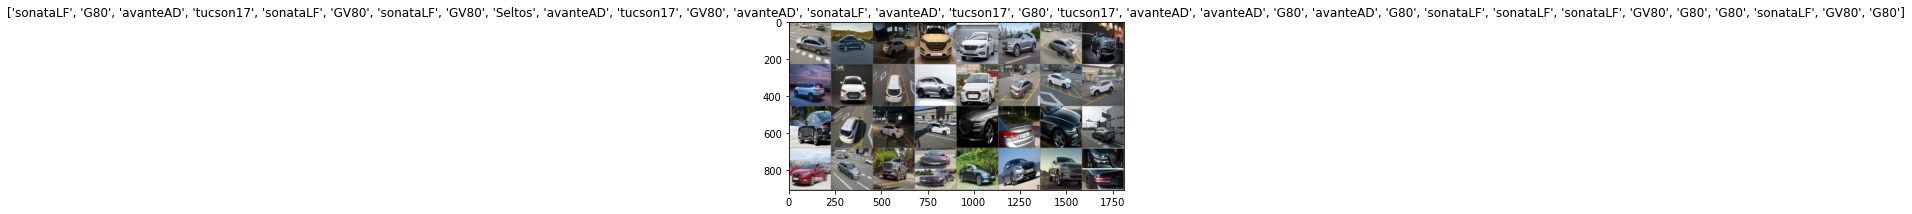

In [ ]:
def imshow(inp, title=None): # 사용할 이미지의 일부를 보여줌(val)
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  

inputs, classes = next(iter(dataloaders['val'])) # 학습 데이터의 배치를 얻습니다.
out = torchvision.utils.make_grid(inputs) # 배치로부터 격자 형태의 이미지를 만듭니다.

imshow(out, title=[class_names[x] for x in classes]) # 이미지 보여주기


In [ ]:
def visualize_model(model, num_images=6): # val 일부이미지에대한 예측값을 보여주는 함수
    was_training = model.training
    model.eval() # 모델을 검증모드로
    images_so_far = 0
    fig = plt.figure() #figure를 만들고 편집 할 수 있게 만들어주는 함수

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]])) # 가장 높은확률의 이름 출력
                imshow(inputs.cpu().data[j]) # 예측하려고 입력된 이미지 보여주기

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [ ]:
#pip install efficientnet_pytorch
model = models.regnet_x_32gf(pretrained=True) # models 사용가능 모델들 : https://pytorch.org/vision/stable/models.html 참고
print(model)

In [ ]:

model.fc=nn.Linear(in_features=2520, out_features=6) # 마지막 출력층을 나의 class 수에 맞춰서 바꿔준다.
print(model) # 바뀐모델 구조 출력

model = model.to(device) # 모델을 gpu로
criterion = nn.CrossEntropyLoss() # 손실함수(loss function) 크로스 엔트로피 사용


RegNet(
  (stem): SimpleStemIN(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (trunk_output): Sequential(
    (block1): AnyStage(
      (block1-0): ResBottleneckBlock(
        (proj): ConvNormActivation(
          (0): Conv2d(32, 336, kernel_size=(1, 1), stride=(2, 2), bias=False)
          (1): BatchNorm2d(336, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (f): BottleneckTransform(
          (a): ConvNormActivation(
            (0): Conv2d(32, 336, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): BatchNorm2d(336, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
          )
          (b): ConvNormActivation(
            (0): Conv2d(336, 336, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=2, bias=False)
            

In [ ]:
# 최적화 기법 설정
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9) # optimizer sgd, 학습률 0.001


In [ ]:
from torchsummary import summary
summary(model, input_size=(3, 224, 224))

In [ ]:
def train_model(model, criterion, optimizer, num_epochs=50): # training 함수 정의
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    train_loss, train_acc, valid_loss, valid_acc = [], [], [], []
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss, running_corrects, num_cnt = 0.0, 0, 0
            
            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                num_cnt += len(labels)
           # if phase == 'train':
            #    scheduler.step()
            
            epoch_loss = float(running_loss / num_cnt)
            epoch_acc  = float((running_corrects.double() / num_cnt).cpu()*100)
            
            if phase == 'train':
                train_loss.append(epoch_loss)
                train_acc.append(epoch_acc)
            else:
                valid_loss.append(epoch_loss)
                valid_acc.append(epoch_acc)
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
           
            # deep copy the model 
            if phase == 'val' and epoch_acc > best_acc:
                best_idx = epoch
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
#                 best_model_wts = copy.deepcopy(model.module.state_dict())
                print('==> best model saved - %d / %.1f'%(best_idx, best_acc))

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best valid Acc: %d - %.1f' %(best_idx, best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts) # accuracy best model 을 저장 한다.
    torch.save(model.state_dict(), '/content/drive/MyDrive/MODELS/non_reg1_2.pt') # 모델을 저장할 자신의 경로 설정
    print('model saved')
    return model, best_idx, best_acc, train_loss, train_acc, valid_loss, valid_acc

In [ ]:
model, best_idx, best_acc, train_loss, train_acc, valid_loss, valid_acc = train_model(model, criterion, optimizer,num_epochs=100)

best model : 51 - 99 / 0.1


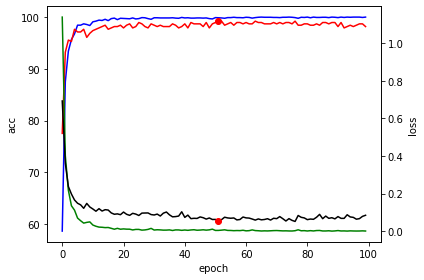

In [ ]:
# 모델 시각화 train, val 의 accuracy , loss 시각화
print('best model : %d - %1.f / %.1f'%(best_idx, valid_acc[best_idx], valid_loss[best_idx]))
fig, ax1 = plt.subplots()

ax1.plot(train_acc, 'b-')
ax1.plot(valid_acc, 'r-')
plt.plot(best_idx, valid_acc[best_idx], 'ro')
ax1.set_xlabel('epoch')
# Make the y-axis label, ticks and tick labels match the line color.
ax1.set_ylabel('acc', color='k')
ax1.tick_params('y', colors='k')

ax2 = ax1.twinx()
ax2.plot(train_loss, 'g-')
ax2.plot(valid_loss, 'k-')
plt.plot(best_idx, valid_loss[best_idx], 'ro')
ax2.set_ylabel('loss', color='k')
ax2.tick_params('y', colors='k')

fig.tight_layout()
plt.show()

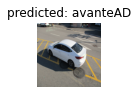

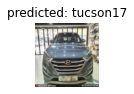

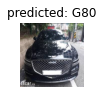

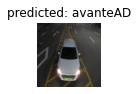

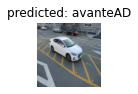

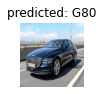

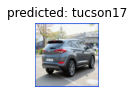

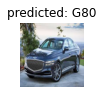

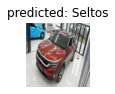

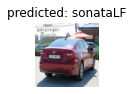

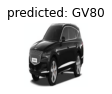

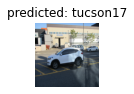

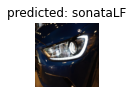

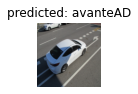

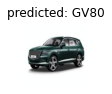

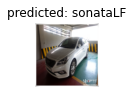

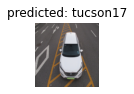

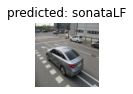

In [ ]:
for x in range(3):
  visualize_model(model) # val 이미지 모델 예측값 시각화

In [ ]:
def test_visualize_model(model, num_images=4): # test 일부 이미지에대한 예측값을 보여주는 함수
    was_training = model.training
    model.eval() # 모델을 검증모드로
    images_so_far = 0
    fig = plt.figure() #figure를 만들고 편집 할 수 있게 만들어주는 함수

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]])) # 가장 높은확률의 이름 출력
                imshow(inputs.cpu().data[j]) # 예측하려고 입력된 이미지 보여주기

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

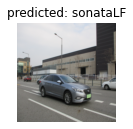

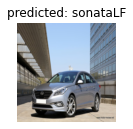

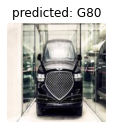

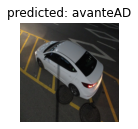

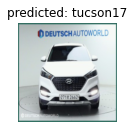

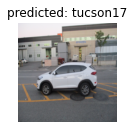

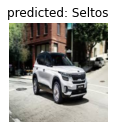

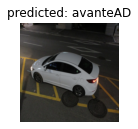

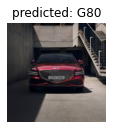

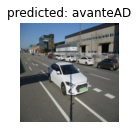

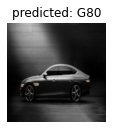

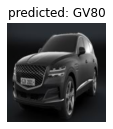

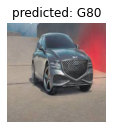

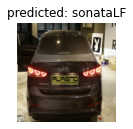

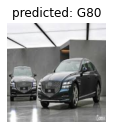

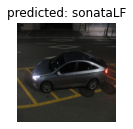

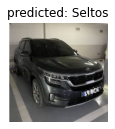

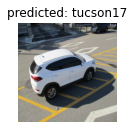

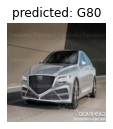

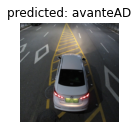

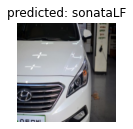

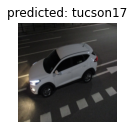

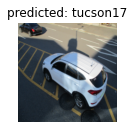

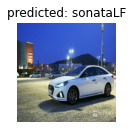

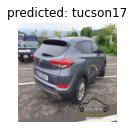

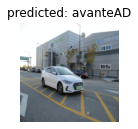

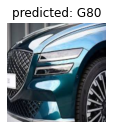

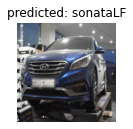

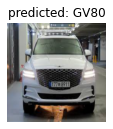

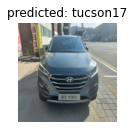

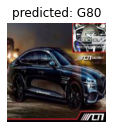

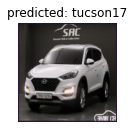

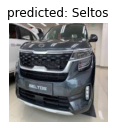

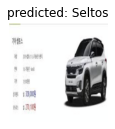

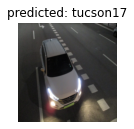

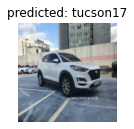

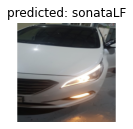

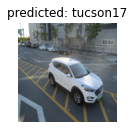

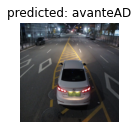

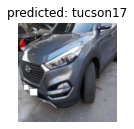

In [ ]:
for x in range(10):
  test_visualize_model(model) # test 이미지 모델 예측값 시각화

In [ ]:
# 각 항목별 정확도 및 컨퓨전 매트릭스 
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt 
nb_classes = 6

confusion_matrix = torch.zeros(nb_classes, nb_classes)
with torch.no_grad():
    for i, (inputs, classes) in enumerate(dataloaders['test']):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1


print('        g80', '    gv80', '   Selots', ' avateAD', 'sonataLF', 'tucson17')
print(confusion_matrix.diag()/confusion_matrix.sum(1))


        g80     gv80    Selots  avateAD sonataLF tucson17
tensor([1.0000, 1.0000, 1.0000, 0.9846, 0.9873, 1.0000])


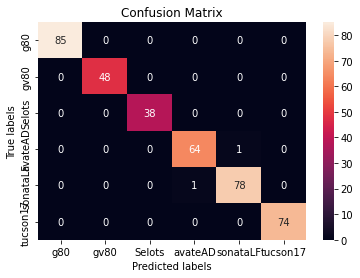

In [ ]:
# 컨퓨전 매트릭스 heatmap 그리기
import seaborn as sns

ax= plt.subplot()
sns.heatmap(confusion_matrix, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['g80', 'gv80', 'Selots', 'avateAD', 'sonataLF', 'tucson17']); ax.yaxis.set_ticklabels(['g80', 'gv80', 'Selots', 'avateAD', 'sonataLF', 'tucson17']);


In [ ]:
## 저장된 모델 경로 지정 하고 불러와서 추론 
from torchvision import models
import torch

model=models.regnet_x_32gf(pretrained=False)
model.fc=nn.Linear(in_features=2520, out_features=6) 

model.load_state_dict(torch.load("/content/drive/MyDrive/MODELS/non_reg1_2.pt", map_location=torch.device('cpu')))
model = model.to(device)

In [ ]:
def test_visualize_model(model, num_images=2): # test Image  예측값을 보여주는 함수
    was_training = model.training
    model.eval() # 모델을 검증모드로
    images_so_far = 0
    fig = plt.figure() # figure를 만들고 편집 할 수 있게 만들어주는 함수

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]])) # 가장 높은확률의 이름 출력
                imshow(inputs.cpu().data[j]) # 예측하려고 입력된 이미지 보여주기

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

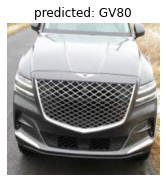

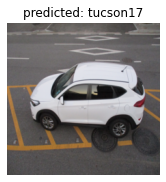

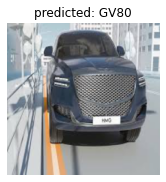

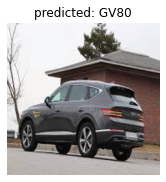

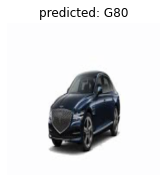

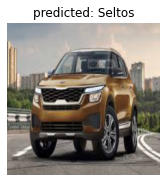

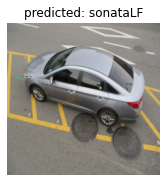

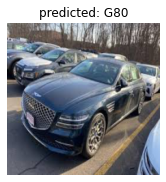

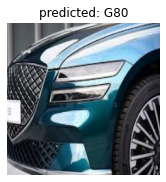

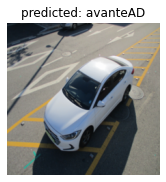

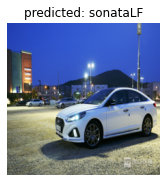

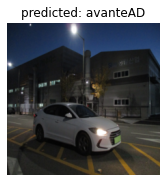

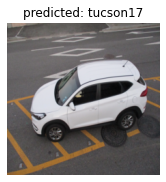

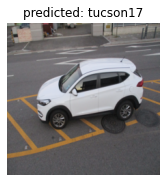

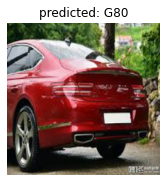

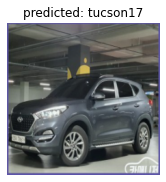

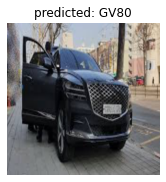

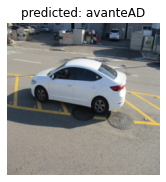

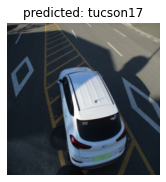

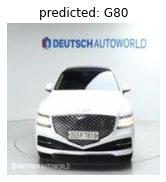

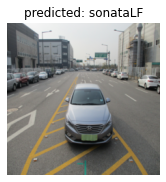

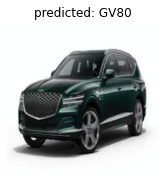

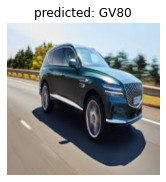

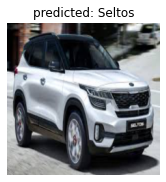

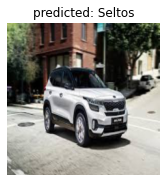

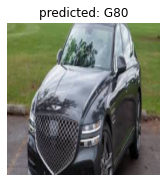

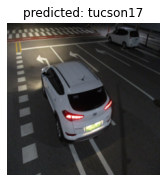

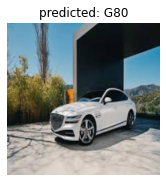

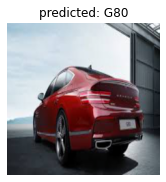

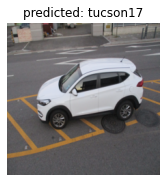

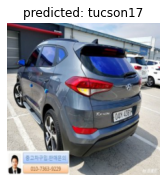

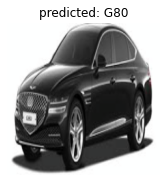

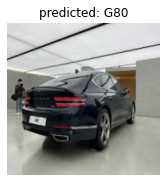

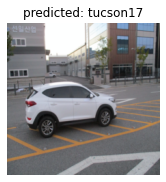

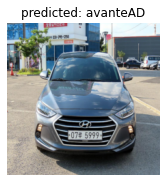

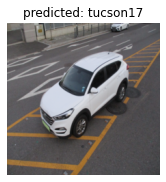

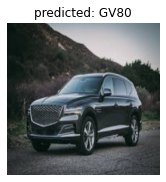

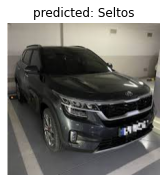

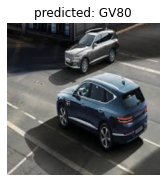

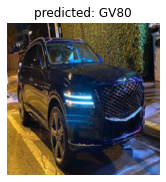

In [ ]:
for x in range(20): # 2개씩 20번 반복 40장
  test_visualize_model(model) # test 이미지 모델 예측값 시각화